In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ../..

/scratch/km817/iREC


In [4]:
import torch
import hamiltorch
import matplotlib.pyplot as plt
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F

In [5]:
%matplotlib inline

In [6]:
hamiltorch.set_random_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
hamiltorch.__version__

'0.4.0.dev1'

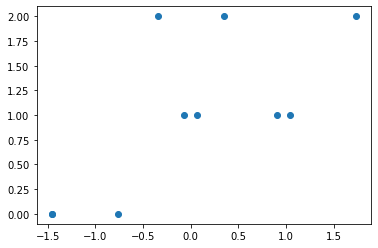

In [8]:
from sklearn.datasets import load_iris
import numpy as np
np.random.seed(0)
device = torch.device('cpu')
data = load_iris()
x_ = data['data']
y_ = data['target']
N_tr = 10#50
N_val = 140
a = np.arange(x_.shape[0])
train_index = np.random.choice(a, size = N_tr, replace = False)
val_index = np.delete(a, train_index, axis=0)
x_train = x_[train_index]
y_train = y_[train_index]
x_val = x_[val_index][:]
y_val = y_[val_index][:]
x_m = x_train.mean(0)
x_s = x_train.std(0)
x_train = (x_train-x_m)/ x_s
x_val = (x_val-x_m)/ x_s
D_in = x_train.shape[1]
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.FloatTensor(y_val)
plt.scatter(x_train.numpy()[:,0],y_train.numpy())
    
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

In [184]:
class Net(nn.Module):
    def __init__(self, num_nodes: int = 10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, num_nodes)
        self.fc2 = nn.Linear(num_nodes, num_nodes)
        self.fc3 = nn.Linear(num_nodes, 3)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
num_nodes = 2
net = Net(num_nodes=num_nodes)


print(net)

Net(
  (fc1): Linear(in_features=4, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=3, bias=True)
)


# MF-VI Approx

In [185]:
from models.BNNs.pyroBNN_classification import BayesianNeuralNetwork
from pyro.infer.autoguide import AutoDiagonalNormal
import pyro
import pyro.distributions as dist
from tqdm.notebook import trange

In [186]:
from models.BNNs.VI_BNN_CLASSIFICTION import VI_BNN

In [ ]:
alpha = 1./10.
ELBO_BETA = 1.
BNN = VI_BNN(alpha=alpha, kl_beta=ELBO_BETA, num_nodes=num_nodes)

opt = torch.optim.Adam(BNN.parameters(), lr=0.1)
pbar = trange(500)
num_bnn_samples_per_epoch = 32
losses = []
for epoch in pbar:
    opt.zero_grad()
    loss = 0
    for i in range(num_bnn_samples_per_epoch):
        y_preds, kld = BNN(x_train)
        loss = loss + BNN.loss_function(y_train, y_preds, kld)
    loss = loss / num_bnn_samples_per_epoch
    loss.backward()
    pbar.set_description(f"The loss is : {loss.item()}")
    losses.append(loss.item())
    opt.step()

  0%|          | 0/500 [00:00<?, ?it/s]

In [224]:
means, stds = BNN.get_mvn_params()

In [241]:
model_loss = 'multi_class_linear_output'

# Effect of tau
tau = alpha # Prior Precision
tau_out = 1. # Output Precision

tau_list = []
for w in net.parameters():
    tau_list.append(tau) # set the prior precision to be the same for each set of weights
tau_list = torch.tensor(tau_list).to(device)


variational_posterior = dist.MultivariateNormal(loc=means, covariance_matrix=torch.diag(stds ** 2))

variational_samps = variational_posterior.sample((10000,))

In [237]:
pred_list_var, _ = hamiltorch.predict_model(net, x=x_val, y=y_val, samples=variational_samples, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

In [238]:
def compute_categorical_mixture(preds, y):
    mix = D.Categorical(torch.ones(preds.shape[0]))
    comp = D.Categorical(logits=preds.permute(1, 0, 2))
    
    mixture_of_categorical = D.MixtureSameFamily(mix, comp)
    mean_preds = torch.argmax(mixture_of_categorical.component_distribution.probs.mean(1), dim=1).float()
    accuracy = torch.sum(mean_preds == y) / y.shape[0]
    
    ll = mixture_of_categorical.log_prob(y).mean()
    return accuracy, ll

In [242]:
pred_list_train, _ = hamiltorch.predict_model(net, x=x_train, y=y_train, samples=variational_samps, 
                                                    model_loss='multi_class_linear_output', tau_out=1., 
                                                    tau_list=tau_list)

In [243]:
compute_categorical_mixture(pred_list_train, y_train)

(tensor(0.4000), tensor(-1.0872))

In [252]:
torch.argmax(BNN(x_train)[0], dim=1)

tensor([1, 0, 0, 0, 0, 0, 1, 1, 0, 0])

In [256]:
y_train

tensor([2., 1., 0., 2., 0., 2., 0., 1., 1., 1.])

In [232]:
prior = D.MultivariateNormal(loc=torch.zeros_like(means), covariance_matrix = 1./alpha * torch.eye(means.shape[-1]))
D.kl_divergence(variational_posterior, prior)

tensor(1.1407)

# Compress some weights with variational scheme

In [ ]:
#### sample weights with compression algorithm
from rec.beamsearch.Coders.Encoder_Variational import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.VariationalPosterior import VariationalPosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler
from rec.OptimisingVars.VariationalOptimiser import VariationalOptimiser
from tqdm.notebook import trange
coding_sampler = CodingSampler
auxiliary_posterior = VariationalPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.



compute_params_enc =  encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)

n_auxiliaries = compute_params_enc.n_auxiliary
kl_q_p = compute_params_enc.total_kl
var_opt = VariationalOptimiser(compute_params_enc.target, omega, n_auxiliaries, kl_q_p, n_trajectories=16, total_var=1./alpha)
aux_vars = var_opt.run_optimiser(epochs=5000, lr=1e-1)

The mean loss is 4.27092. The mean KL is: 4.92127:  56%|█████▌    | 2803/5000 [27:18<20:23,  1.80it/s] 

In [63]:
kl_q_p

tensor(45.1838)

In [65]:
initial_seed = 0
beamwidth = 1
epsilon = 0.

compressed_weights_low_eps = []
num_compressed_samples = 250
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    w, idx = encoder.run_encoder()

    compressed_weights_low_eps.append(w[0])

  0%|          | 0/250 [00:00<?, ?it/s]

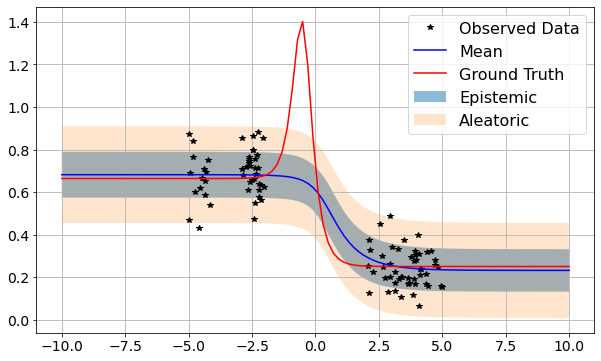

In [66]:
pred_list_var_low_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_low_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_var_low_eps)

In [67]:
initial_seed = 0
beamwidth = 1
epsilon = 0.1

compressed_weights_var_med_eps = []
num_compressed_samples = 250
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    w, idx = encoder.run_encoder()

    compressed_weights_var_med_eps.append(w[0])

  0%|          | 0/250 [00:00<?, ?it/s]

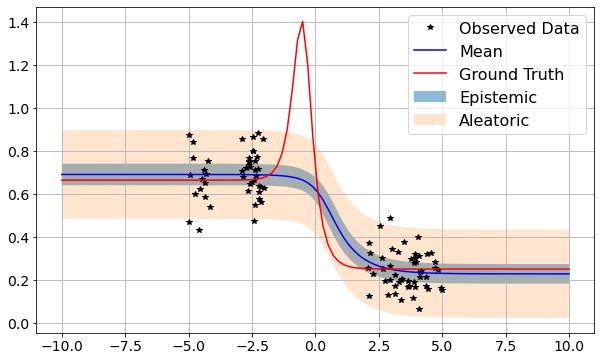

In [68]:
pred_list_var_med_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_var_med_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)
plot_preds(pred_list_var_med_eps)

In [69]:
initial_seed = 0
beamwidth = 1
epsilon = 0.2

compressed_weights_var_high_eps = []
num_compressed_samples = 250
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    w, idx = encoder.run_encoder()

    compressed_weights_var_high_eps.append(w[0])

  0%|          | 0/250 [00:00<?, ?it/s]

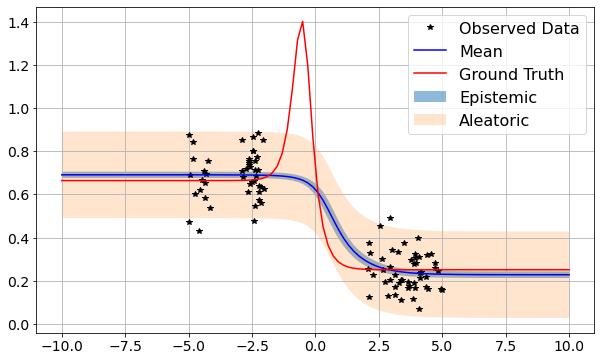

In [70]:
pred_list_var_high_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_var_high_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)
plot_preds(pred_list_var_high_eps)

In [71]:
def make_empirical_predictive(weights, x_input, y_output):
    pred_list, _ = hamiltorch.predict_model(net, x = x_input.flatten().to(device),
                                                  y = y_output.flatten().to(device), samples=weights,
                                                  model_loss='regression', tau_out=tau_out,
                                                  tau_list=tau_list)
    
    # need to make gmm at each sample
    return pred_list

def make_empirical_gmm(preds):
    mix = D.Categorical(torch.ones(preds.shape[0]))
    comp = D.Normal(loc=preds.squeeze().permute(1, 0), scale=beta ** -0.5)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm

def compute_gmm_lp(weights, x, y):
    preds = make_empirical_predictive(weights, x, y)
    
    gmm = make_empirical_gmm(preds)
    
    return gmm.log_prob(y.squeeze()).sum()

In [72]:
compute_gmm_lp(variational_samples, x_test, y_test)

tensor(80.1591)

In [73]:
compute_gmm_lp(variational_samples, x_data, y_data)

tensor(87.0769)

In [74]:
compute_gmm_lp(compressed_weights_low_eps, x_test, y_test)

tensor(91.1210)

In [75]:
compute_gmm_lp(compressed_weights_var_med_eps, x_test, y_test)

tensor(98.3910)

In [76]:
compute_gmm_lp(compressed_weights_var_high_eps, x_test, y_test)

tensor(80.6953)

In [77]:
# dump the important stuff
import pickle as pkl
pkl.dump(variational_posterior, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_post_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(aux_vars, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_optimised_vars_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(kl_q_p, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_kl_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(variational_samples, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_exact_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(compressed_weights_low_eps, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_beta_{ELBO_BETA}_eps_0.pkl', 'wb'))
pkl.dump(compressed_weights_var_med_eps, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_beta_{ELBO_BETA}_eps_0.1.pkl', 'wb'))
pkl.dump(compressed_weights_var_high_eps, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_beta_{ELBO_BETA}_eps_0.2.pkl', 'wb'))